In [1]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F   # All functions that don't have any parameters



In [2]:

# Setting Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epoch = 100

In [5]:
train_dataset = torchvision.datasets.MNIST(root= './data',train = True,transform= transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root= './data',train = False,transform= transforms.ToTensor(),download=True)

noise_train_dataset = np.zeros((len(train_dataset),1,28,28))
noise_test_dataset = np.zeros((len(test_dataset),1,28,28))

for i in range(len(train_dataset)):
  if i < len(train_dataset)//2:
    noise_train_dataset[i][0] = gaussian_noise(train_dataset[i][0][0])
  else:
    noise_train_dataset[i][0] = speckle_noise(train_dataset[i][0][0])

for i in range(len(test_dataset)):
  if i < len(test_dataset)//2:
    noise_test_dataset[i][0] = gaussian_noise(test_dataset[i][0][0])
  else:
    noise_test_dataset[i][0] = speckle_noise(test_dataset[i][0][0])



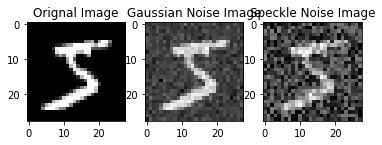

In [4]:
def gaussian_noise(img):
  sigma = 0.1
  mu = 0 
  noise = np.random.normal(mu,sigma,img.shape)
  return img + noise

def speckle_noise(img):
  row,col = img.shape
  noise = np.random.rand(row,col)
  return img + noise

import numpy as np
img = train_dataset[0][0][0]

plt.subplot(1,3,1)
plt.imshow(img,cmap = "gray")
plt.title("Orignal Image")
noise_img = gaussian_noise(img)
noise_img2 = speckle_noise(img)
plt.subplot(1,3,2)
plt.title("Gaussian Noise Image")
plt.imshow(noise_img,cmap = "gray")
plt.subplot(1,3,3)
plt.title("Speckle Noise Image")
plt.imshow(noise_img2,cmap = "gray")

In [6]:
class MNIST_dataset(Dataset):
  def __init__(self,input,label,transform = None):
    self.input = input
    self.label = label
    self.transform = transform

  def __len__(self):
    return len(self.input)
  
  def __getitem__(self,indx):
    #print(self.input.shape,self.)
    img = self.input[indx]
    label = self.label[indx][0]
    
    if self.transform:
      img = self.transform(img)
      label= self.transform(label)
    return img,label

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x



In [7]:

train_set = MNIST_dataset(noise_train_dataset,train_dataset)
test_set = MNIST_dataset(noise_test_dataset,test_dataset)

In [8]:
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_set,batch_size = batch_size,shuffle=True)

img,label = iter(test_loader).next()
print(img.shape,label.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28])


In [9]:
def train(model,device,train_loader,criterion, optimizer,epoch):
    model.train()
    for i ,(data,targets) in enumerate(train_loader):
        data, targets = data.view(data.shape[0],-1).float(),targets.view(targets.shape[0],-1).float()
        data,targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%2000 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(data), len(train_loader.dataset),
                                            100. * i / len(train_loader), loss.item()))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(data.shape[0],-1).float(),target.view(target.shape[0],-1).float()
            output = model(data)
            test_loss += criterion(output, target)# sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}'.format(test_loss, correct))

In [ ]:
model = denoising_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

schedular = optim.lr_scheduler.StepLR(optimizer,step_size= 3, gamma = 0.1)
print("training Model")
for epoch in range(num_epoch):
    train(model,device,train_loader,criterion,optimizer,epoch)
    schedular.step()
    test(model,device,test_loader)
    if epoch%10 ==0:
      torch.save(model.state_dict(),'seg_model.pth')


In [12]:
torch.load(model.state_dict(),'seg_model.pth')

In [16]:
img,label= iter(train_loader).next()
img1 = img[0].view(img[0].shape[0],-1).float()
print(img1.shape)
predict = model(img1.to(device))
label = label[0][0].detach().numpy()

torch.Size([1, 784])


In [17]:
predict_img = predict.view(1,28,28).detach().cpu().numpy()

Text(0.5, 1.0, 'Predicted Image')

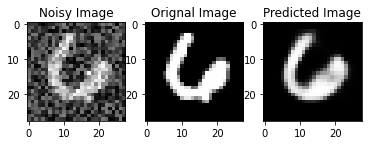

In [21]:
plt.subplot(1,3,1)
plt.imshow(img[0][0],cmap = "gray")
plt.title("Noisy Image")
plt.subplot(1,3,2)
plt.imshow(label,cmap = "gray")
plt.title("Orignal Image")
plt.subplot(1,3,3)
plt.imshow(predict_img[0],cmap = "gray")
plt.title("Predicted Image")
